# **TELCO CHURN PREDICTION**

## **A. All Packages be used on this project**

In [3]:
# packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


## **B. DATASET**

In [4]:
# load dataset
from dotenv import load_dotenv
import os
load_dotenv()  

# 1. LIS_dataset -> main dataset
lis_dataset = os.getenv("lis_dataset_path")
df_lis = pd.read_excel(lis_dataset, sheet_name="lis_telco")

# 2. churn_dataset -> main dataset
churn_dataset = os.getenv("churn_dataset_path")
df_churn = pd.read_excel(churn_dataset, sheet_name="Sheet1")

# 3. Unbill Dataset -> main dataset
# 3.1 Unbill New
unbill_new_dataset = os.getenv("unbill_new_path")
df_unbill_new = pd.read_excel(unbill_new_dataset, sheet_name="ct0_new")

# 3.2 Unbill old 
unbill_old_dataset = os.getenv("unbill_old_path")
df_unbill_old = pd.read_excel(unbill_old_dataset, sheet_name="ct0_old")

# 4. Customer Payment Habit -> support dataset
habit_bayar_dataset = os.getenv("habit_bayar_dataset_path")
df_habit_bayar = pd.read_excel(habit_bayar_dataset, sheet_name="Export Worksheet")

# 5 Territory Mapping
territory_map_path = os.getenv("territory_map_path")
df_territory_map = pd.read_excel(territory_map_path, sheet_name="dim_telda_bill")


## **C. DATA PRE-PROCESSING**

### **C.1 LIS DATASET**

#### **C.1.1 DATA CLEANING**

In this section, we applied several filtering steps to ensure the dataset is relevant for churn analysis:
  - Removed irrelevant columns that don't contribute to churn prediction.
  - Filtered out non-RBS customers by keeping only rows where UNIT2 == 'RBS'.
  - Excluded entries where DAPROS_ALL == 'WMS', as they fall outside the scope of our analysis.

In [5]:
raw_lis = df_lis.copy()

# 1. drop unecessary columns
raw_lis = raw_lis.drop(columns=['KW_IH','AMBANG','NCLI','CITEM','PRODTYPE','IS_INDIHOME','CEK_WICO','UNIT','CEK_LGEST','INET_BASIC','LGEST','PACK_NAME','PLBLCL','Rev (Rp M)','TREMS_REV_P','ADDON','ALAMAT','AMBANG2','ASSET_ROWID','BA_ROWID','BLN_TGK','CA_ROWID','Calculation2','CEK_CGEST','CEK_2P','CEK_3P','CEK_HSIE','CEK_HSSP','CEK_HSSP (copy)','CEK_LOY','CEK_P_HSI','CEK_TO','CGEST','CITEM_EXT','EKOSISTEM','EMAIL','F_PRIORITY','F_PRIORITY_DESC','GROUP_HSIE','GROUP_PRO_HW','GRP_PRODUK','HARGA_HSI','HARGA_ONT','HSIE RECOM','HSSP RECOM','IHOME_INV','INET_OTHERS','IPSTATIC','JKW1','JKW2','JKW3','JKW4','KET_MIGRASI','KET_RESL','KET_SELLER','KW_IH2','KW_POTS','KW_UM_TXT','KW_UMUR','L_AMBANG','L_KW_UMUR','LINECATS_ITEM_ID','LINKAR','LOY_PROGRAM','NAMA','NAMA_AM','ND_REFERENCE','NDOS','NIK_AM','NIPNAS','NO_HP','P_DIGITAL','PKW1','PKW2','PKW3','PKW4','PRIO_MIG','PRIORITAS_MIG','PRIORITY','PRODUK2','REALM','RECOM_DIGI','REV (Jt)','REV INET(M)','REV VOICE (M)','REV_TXT','REV(M)','REVENUE_ADDON_INET','REVENUE_ADDON_TV','REVENUE_INET','REVENUE_TV','RID','ROOT_ASSET_ID','SELISIH','SELISIH2','SPEED','TAG_OTHER','TAHUN_PS','TECHNO','titik','TOT_TGK','TREMS_REV','TREMS_REV_REF','UNIT (copy)','UMUR PLG (Th)'],axis=1)


# 2. drop rows with not RBS values in ['UNIT2']
raw_lis =raw_lis[raw_lis['UNIT2'] == "RBS"]

# 3. drop rows with WMS values in ['DAPROS']
raw_lis =raw_lis[raw_lis['DAPROS_ALL'] != "WMS"]

#### **C.2.2 MISSING VALUES HANDLING**

In this step, we handled missing values for several key columns:

For the following columns: ADDON_PRICE, ADDON_TOTAL, IS_IPTV, and IS_POTS,
we replaced all missing values with 0 to ensure consistency and avoid issues during model training.
This approach assumes that missing values in these fields likely indicate the absence of the respective feature.

In [6]:
# missing values handling

# 1. missing values in ['ADDON_PRICE'] will be replaced with 0
raw_lis['ADDON_PRICE'] = raw_lis['ADDON_PRICE'].fillna(0)

# 2. missing values in ['ADDON_TOTAL'] will be replaced with 0
raw_lis['ADDON_TOTAL'] = raw_lis['ADDON_TOTAL'].fillna(0)

# 3. missing values in ['IS_IPTV'] will be replaced with 0
raw_lis['IS_IPTV'] = raw_lis['IS_IPTV'].fillna(0)

# 4. missing values in ['IS_POTS'] will be replaced with 0
raw_lis['IS_POTS'] = raw_lis['IS_POTS'].fillna(0)


#### **C.2.3 DATA FORMATTING & TRANSFORMING**

In this section, we cleaned up some formatting issues and applied a few transformations to make the data more consistent and usable:

  - Formatted TGL_PS as a proper date column.
  - Converted NOTEL to string type to ensure consistency in customer identifiers.
  - Transformed BW by replacing 'BW_NULL' values with 0, then converted the column to int64.
  - Handled duplicates by dropping rows with the same NOTEL, keeping only the one with the smallest value in UMUR_PSB.
  - Adjusted LOS by adding +1 to each value, since we want to calculate the length of subscription in months (starting from month 1 instead of 0).

In [7]:
# data formatting

# 1. convert 'TGL_PS' from object to date
raw_lis['TGL_PS'] = pd.to_datetime(raw_lis['TGL_PS'], format='%m/%d/%Y %I:%M:%S %p')

# 2.1 Remove '_DEL' substring from NOTEL values
raw_lis['NOTEL'] = raw_lis['NOTEL'].astype(str).str.replace('_DEL', '', regex=False)
# 2.2 Convert NOTEL to numeric (string)
raw_lis['NOTEL'] = pd.to_numeric(raw_lis['NOTEL'], errors='coerce').astype(str)

# 3. transform ['Speed (MBps)'] == 'BW_NULL' as 0
raw_lis['Speed (MBps)'] = raw_lis.loc[raw_lis['Speed (MBps)'] == 'BW_NULL', 'Speed (MBps)'] = 0

# 4.1 Remove '_DEL' substring from NOTEL values
raw_lis['NOTEL'] = raw_lis['NOTEL'].astype(str).str.replace('_DEL', '', regex=False)

# 4.2 Convert NOTEL to numeric (str)
raw_lis['NOTEL'] = pd.to_numeric(raw_lis['NOTEL'], errors='coerce').astype(str)

# 5. drop duplicate rows based on NOTEL and keep only the row with the smallest value in ['UMUR_PSB']
raw_lis = raw_lis.sort_values('UMUR_PSB').drop_duplicates(subset=['NOTEL'], keep='first')

# 6. Transforming LOS -> values should be +1 
raw_lis['LOS'] = raw_lis['LOS'] + 1



#### **C.2.4 DATASET FINALIZATION**

In [8]:
# 1. Generate Dataset
df_lis_final = raw_lis[['NOTEL','ASSET_STATUS','KW_INET','TELDA','WITEL','ARPU','BW','IS_IPTV','PERIOD_PS','UMUR_PSB','PERIOD','LOS','STO']].copy()

# 2. rename columns name
df_lis_final = df_lis_final.rename(columns={
    'NOTEL': 'SND',
    'ASSET_STATUS': 'CHURN_FLAG',
    'KW_INET': 'KWADRAN',
    'TELDA': 'TELDA',
    'WITEL': 'WITEL',
    'ARPU': 'ARPU',
    'BW': 'SPEED',
    'IS_IPTV': 'IPTV_FLAG',
    'PERIOD_PS': 'MONTH_PS',
    'PERIOD': 'LAST_ACTIVE',
    'LOS': 'TENURE_MONTH',
    'STO': 'STO',
})

# 3. Transforming ['SPEED'] 
# Remove 'BW_' and 'M' from 'SPEED' column, keep only the number, NULL replaced with 0
df_lis_final['SPEED'] = (
    df_lis_final['SPEED']
    .str.replace(r'BW_|M|<', '', regex=True)
    .str.replace(' ', '') # remove all spaces
    .str.strip() ) # remove leading/trailing spaces if any remain

df_lis_final['SPEED'] = df_lis_final['SPEED'].str.replace(r'<10', '10', regex=True).str.strip()
df_lis_final['SPEED'] = df_lis_final['SPEED'].str.replace(r'NULL', '0', regex=True).str.strip()

# 4. Convert ['SPEED'] datatype into float
df_lis_final['SPEED'] = df_lis_final['SPEED'].astype('float64')


### **C.2 CHURN DATASET**

#### **C.2.1 DATA CLEANING**

In this section, we removed columns that are not relevant to churn analysis. This helps simplify the dataset and ensures that the model focuses only on meaningful features.

In [9]:
raw_churn = df_churn.copy()

# 1. drop columns that are not relevant to churn analysis
raw_churn = raw_churn.drop(columns=['L_EKOSISTEM','PRODUK','REGIONAL (NEW_TERRITORY)','TAHUN','DIVISI','HSI_B2B','ND_HSI_IPTV','NCLI','CHANNEL','L_CHANNEL'],axis=1)

# 2. Drop WMS values in ['PRODUK']
raw_churn = raw_churn[raw_churn['L_PRODUK'] != 'WMS']

#### **C.2.2 DATA FORMATTING**

In this section, we fixed incorrectly formatted data types and applied a few transformations to improve data quality: 
 - Formatted TGL_PSB and TGL_PS: These columns were originally stored as numeric values, so we converted them into proper date formats.
 - Converted SPEEDY to string type to ensure consistent formatting.
 - Transformed UBIS: Replaced values labeled as "Business" with "RBS" to align with our segmentation.
 - Created a new feature MONTH_PS: This column represents the subscription month in YYYYMM format, derived from TGL_PSB 

In [12]:
# Date Handling

# 1. convert raw_churn[['TGL_PSB','TGL_PS']] to datetime
raw_churn['TGL_PSB'] = pd.to_datetime(raw_churn['TGL_PSB'], format='%Y%m%d')
raw_churn['TGL_PS'] = pd.to_datetime(raw_churn['TGL_PS'], format='%Y%m%d')

# 2. Convert['SPEEDY'] as string
raw_churn['SPEEDY'] = raw_churn['SPEEDY'].astype(str)

# 3. Transform [DIVISI] == 'Business' as 'RBS'
raw_churn['UBIS'] = raw_churn.loc[raw_churn['UBIS'] == 'Business', 'DIVISI'] = 'RBS'

# 4. Add new Feature ['MONTH_PS'], values filled from extraction of YYYYMM ['TGL_PSB']
raw_churn['MONTH_PSB'] = raw_churn['TGL_PSB'].dt.strftime('%Y%m').astype('Int64')

#### **C.2.3 DATASET FINALIZATION**

In [14]:
# generate final churn dataset
df_churn_final = raw_churn[['SPEEDY','MONTH_PSB','CITEM','WITEL (NEW_TERRITORY)','TELKOM_DAERAH','STO','IS_IPTV','SSL_DO','PERIODE']]

# 2. Rename columns in df_churn_final
df_churn_final = df_churn_final.rename(columns={
    'SPEEDY': 'SND',
    'MONTH_PSB': 'MONTH_PS',
    'MONTH_DIFF': 'TENURE_MONTH',
    'CITEM': 'SPEED',
    'WITEL (NEW_TERRITORY)': 'WITEL',
    'TELKOM_DAERAH': 'TELDA',
    'STO': 'STO',
    'IS_IPTV': 'IPTV_FLAG',
    'SSL_DO': 'CHURN_FLAG',
    'PERIODE' : 'LAST_ACTIVE'
})

# 3. Data Type Format
df_churn_final['CHURN_FLAG'] = df_churn_final['CHURN_FLAG'].astype(bool)

# 4. Add New Feature = 'KWADRAN' == Churn == 1 (no bill & no usage)
df_churn_final['KWADRAN'] = 1

# 5. Keep only the number from the 'SPEED' column, set to NaN if no number found
df_churn_final['SPEED'] = df_churn_final['SPEED'].astype(str).str.extract(r'(\d+)', expand=False).astype(float).fillna(0)
df_churn_final.loc[df_churn_final['SPEED']>300,['SPEED']] = df_churn_final.loc[df_churn_final['SPEED']>300,['SPEED']] / 1000
df_churn_final.loc[df_churn_final['SPEED'] < 10, 'SPEED'] = 0
df_churn_final.loc[df_churn_final['SPEED'] == 15, 'SPEED'] = 20

# 6. add new feature 'ARPU' based on SPEED-ARPU mapping in df_lis_final
mapping_arpu = df_lis_final[['SPEED','ARPU']].groupby('SPEED').agg({'ARPU': 'mean'}).sort_values(by='ARPU', ascending=False)

df_churn_final = df_churn_final.merge(mapping_arpu, how='left', left_on='SPEED',right_on='SPEED', suffixes=('', '_ARPU'))

### **C.3 UNBILL DATASET**

#### **C.3.1 DATA MERGING**

In this section, we started by merging two unbill datasets into a single, unified dataset. This step helps simplify the data pipeline and ensures we have a complete view of all unbill records for churn labeling.

In [19]:
# merged unbill dataset
raw_unbill = pd.concat([df_unbill_new, df_unbill_old], ignore_index=True)

#### **C.3.2 DATA CLEANING**

In this section, we chose to drop columns that are not relevant to churn prediction. This helps streamline the dataset and ensures the model focuses only on meaningful features.

In [20]:
# drop not relevant columns
raw_unbill = raw_unbill.drop(columns=['JML LYN','AGENT','AGENT_ID','ALAMAT','Bisnis Area','CCA','Centite','CHANNEL_OK','CUSTOMER_NAME','Datms','Datrs','DEPOSIT','Divisi','JML_BLN_BAYAR','JML_BLN_NUNGGAK','KCONTACT','NAMA_AGENT','NAMA_CONTACT','NCLI','NIPNAS','NO_CONTACT','Number of Records','OLD_TREG','OLD_WITEL','ORDER_NO','Paket Fbip','Paket Speedy Desc','Pemakaian','STANDARD_NAME','Segmen','Status','Subsegmen','Total','Total Lalu (M)','Total Net','Total Net Lalu','Type Pohon','Ubis','Witel','TAHUN','Abonemen','Abonemen Lalu','Debit','LAST_BAYAR','LAST_PERIODE','PPN','Ppn Lalu','TAHUN PS'])

raw_unbill = raw_unbill[raw_unbill['Indihome Desc'] != 'WMS']

#### **C.3.3 DATA FORMATTING & TRANSFORMATION**

In this section, we fixed a formatting issue in the dataset: Converted SND to string type to ensure consistent formatting across all records.

In [21]:
# 1. format ['SND'] as string
raw_unbill['SND'] = raw_unbill['SND'].astype(str)

#### **C.3.4 FEATURE ENGINEERING**

In this section, we created new features and transformed existing ones to help the model better understand customer behavior and patterns related to churn.

In [22]:
# 1. Add new Feature 'FLAG_IPTV' as IPTV or not IPTV when ['Bundling'] == '3P' or ['Indihome Desc'] == 'INET_TV'
raw_unbill.loc[raw_unbill['Bundling'] == '3P', ['FLAG_IPTV']]  = "IPTV"
raw_unbill.loc[raw_unbill['Indihome Desc'] == 'INET_TV', ['FLAG_IPTV']]  = "IPTV"
raw_unbill['FLAG_IPTV'].fillna('NOT IPTV')

# 2. add new feature 'STO' as first 3 characters of 'Sto Desc'
raw_unbill['STO'] = raw_unbill['Sto Desc'].str[:3]

#### **C.3.5 MISSING VALUE HANDLING**

In this section, we handled missing values more selectively across several features:

  - Witel Bill → filled missing values by mapping from Datel, using a predefined mapping between Datel and Witel.
  - SND, BULAN PS, and Group Portfolio → rows with missing values in these columns were dropped, as they are considered essential for the analysis.

In [23]:
# 1. ['Witel Bill'] -> missing values should be filled utilizing datel values (mapped witel based on datel)
raw_unbill = raw_unbill.merge(df_territory_map[['ID_TELDA_BILL', 'WITEL','TELDA_BILL']], left_on='Datel', right_on='ID_TELDA_BILL', how='left').drop(columns=['Witel Bill'])

# 2. ['SND'] -> with missing values should be dropped
raw_unbill = raw_unbill.dropna(subset=['SND'])

# 3. ['BULAN PS'] -> with missing values should be dropped
raw_unbill = raw_unbill.dropna(subset=['BULAN PS'])

# 4. ['Group Portfolio'] -> with missing values should be dropped
raw_unbill = raw_unbill.dropna(subset=['Group Portfolio'])

#### **C.3.6 DATASET FINALIZATION**

In [24]:
# 1. Generate Dataset
df_unbill_final = raw_unbill[['SND','WITEL','TELDA_BILL','BULAN PS','Umur Plg','Total Lalu','FLAG_IPTV','Usage Desc','Nper','STO']].copy()

# 2. Add New Feature = 'KWADRAN' == unbilll == 1
df_unbill_final['KWADRAN'] = 1

# 3. Add New Feature = 'SPEED' that value is based 'SPEED' from df_lis_final
df_unbill_final = df_unbill_final.merge(df_lis_final[['SND','SPEED']],how='left', on='SND', suffixes=('', '_LIS'))

# 4. Rename feature names
df_unbill_final = df_unbill_final.rename(columns={
    'TELDA_BILL': 'TELDA',
    'BULAN PS' : 'MONTH_PS',
    'Umur Plg': 'TENURE_MONTH',
    'Usage Desc': 'CHURN_FLAG',
    'Nper': 'LAST_ACTIVE',
    'KWADRAN': 'KWADRAN',
    'SPEED': 'SPEED',
    'STO': 'STO',
    'FLAG_IPTV': 'IPTV_FLAG',
    'Total Lalu': 'ARPU'
})

### **C.4 PAYMENT HABIT DATASET**

#### **C.4.1 DATA CLEANING**

In this section, we reduced the dataset by applying several filters to focus only on relevant data for churn prediction:

  - Dropped columns that are not useful for churn analysis.
  - Removed non-SME customers, keeping only entries from the SME segment.
  - Excluded records where the service type is TLP, as they fall outside the scope of our analysis.

In [15]:
raw_payment_habit = df_habit_bayar.copy()

# 1. Drop columns that are not relevant to churn analysis
raw_payment_habit = raw_payment_habit.drop(columns=['ACCOUNT_NUM','ABONTAG','IDBA','CCAT','CENTITE','NAMA','ALAMAT','CCA','DATRS','NCLI','LGEST','CP','STATUS_BILL','TGL_KLAIM','LAYANAN','JHARI'],axis=1)

# 2. drop rows with not RBS values in ['SEGMEN']
raw_payment_habit = raw_payment_habit.loc[raw_payment_habit['SEGMEN'] == 'RBS',]

# 3. drop rows with  TLP values in ['PRODUK']
raw_payment_habit = raw_payment_habit.loc[raw_payment_habit['PRODUK'] != 'TLP',]

#### **C.4.2 DATA TRANSFORMATION**

In this section, we applied a few transformations related to customer payment behavior:

  - Transformed BUNDLING values: If BUNDLING == 2P and both LAYANAN_TV and SND_GROUP are not null, we updated the value to 3P to reflect a more complete service bundle.
  - Formatted SND: Converted the column to int64 to ensure consistent numeric formatting.

In [17]:
# Data Transforming

# 1. transform ['BUNDLING'] == '2P' and ['LAYANAN_TV'] is not null and ['SND_GROUP'] is not null as '3P'
raw_payment_habit['BUNDLING'] = raw_payment_habit.loc[(raw_payment_habit['BUNDLING'] == '2P') & (~raw_payment_habit['LAYANAN_TV'].isnull()) & (~raw_payment_habit['SND_GROUP'].isnull()), ['BUNDLING']]= '3P'

# Data Formatting
# 2. convert ['SND'] from object to string
raw_payment_habit['SND'] = raw_payment_habit['SND'].astype(str)

#### **C.4.3 MISSING VALUE HANDLING**

In this section, we handled missing values across several important features to ensure data consistency:

  - EKSEPSI → replaced missing values with "N".
  - USAGETAG, TIKET_C, TIKET_D, RP_BAYAR, and RP_KLAIM → replaced missing values with 0.
  - IS_PRANPC → replaced missing values with "NOT PRANPC" to indicate customers not in the PRANPC category.

These replacements help maintain data integrity and prevent issues during model training.

In [18]:
# Missing Value Handling

# 1. missing values in ['EKSEPSI'] will be replaced with N
raw_payment_habit['EKSEPSI'] = raw_payment_habit['EKSEPSI'].fillna('N')

# 2. missing values in ['USAGETAG'] will be replaced with 0
raw_payment_habit['USAGETAG'] = raw_payment_habit['USAGETAG'].fillna(0)

# 3. missing values in ['TIKET_C'] will be replaced with 0
raw_payment_habit['TIKET_C'] = raw_payment_habit['TIKET_C'].fillna(0)

# 4. missing values in ['TIKET_D'] will be replaced with 0
raw_payment_habit['TIKET_D'] = raw_payment_habit['TIKET_D'].fillna(0)

# 5. missing values in ['IS_PRANPC'] will be replaced with 0
raw_payment_habit['IS_PRANPC'] = raw_payment_habit['IS_PRANPC'].fillna('NOT PRANPC')

# 6. missing values in ['RP_BAYAR'] will be replaced with 0
raw_payment_habit['RP_BAYAR'] = raw_payment_habit['RP_BAYAR'].fillna(0)

# 7. missing values in ['RP_KLAIM'] will be replaced with 0
raw_payment_habit['RP_KLAIM'] = raw_payment_habit['RP_KLAIM'].fillna(0)

# **DATASET FINAL BANGET**

In [25]:
# generate fix dataset

# 1. sort df_list_final features as df_churn_final
df_lis_final = df_lis_final[['SND','MONTH_PS','TENURE_MONTH','SPEED','WITEL','TELDA','STO','IPTV_FLAG','CHURN_FLAG','LAST_ACTIVE','KWADRAN','ARPU']]

# 2. sort df_unbill_final features as df_churn_final
df_unbill_final = df_unbill_final[['SND','MONTH_PS','TENURE_MONTH','SPEED','WITEL','TELDA','STO','IPTV_FLAG','CHURN_FLAG','LAST_ACTIVE','KWADRAN','ARPU']]

# 3. vertical stack all three dataframe
df_churn_prediction = pd.concat([df_churn_final, df_lis_final, df_unbill_final], axis=0).reset_index(drop=True)

In [26]:
# save dataset
df_churn_prediction.to_excel('df_churn_prediction.xlsx', index=False)

In [27]:
df_churn_prediction.isnull().any(axis=0)

SND             False
MONTH_PS         True
SPEED            True
WITEL           False
TELDA           False
STO              True
IPTV_FLAG        True
CHURN_FLAG       True
LAST_ACTIVE     False
KWADRAN         False
ARPU            False
TENURE_MONTH     True
dtype: bool

In [31]:
test = df_churn_prediction.merge(df_habit_bayar[['SND','TYPE']],how='left',left_on='SND',right_on='SND',suffixes=('', '_HABIT'))

In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201329 entries, 0 to 201328
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   SND           201329 non-null  object 
 1   MONTH_PS      201188 non-null  Float64
 2   TENURE_MONTH  201188 non-null  float64
 3   SPEED         149982 non-null  float64
 4   WITEL         201329 non-null  object 
 5   TELDA         201329 non-null  object 
 6   STO           201328 non-null  object 
 7   IPTV_FLAG     145956 non-null  object 
 8   CHURN_FLAG    199482 non-null  object 
 9   LAST_ACTIVE   201329 non-null  int64  
 10  KWADRAN       201329 non-null  int64  
 11  ARPU          191471 non-null  float64
 12  TYPE          85871 non-null   object 
dtypes: Float64(1), float64(3), int64(2), object(7)
memory usage: 20.2+ MB


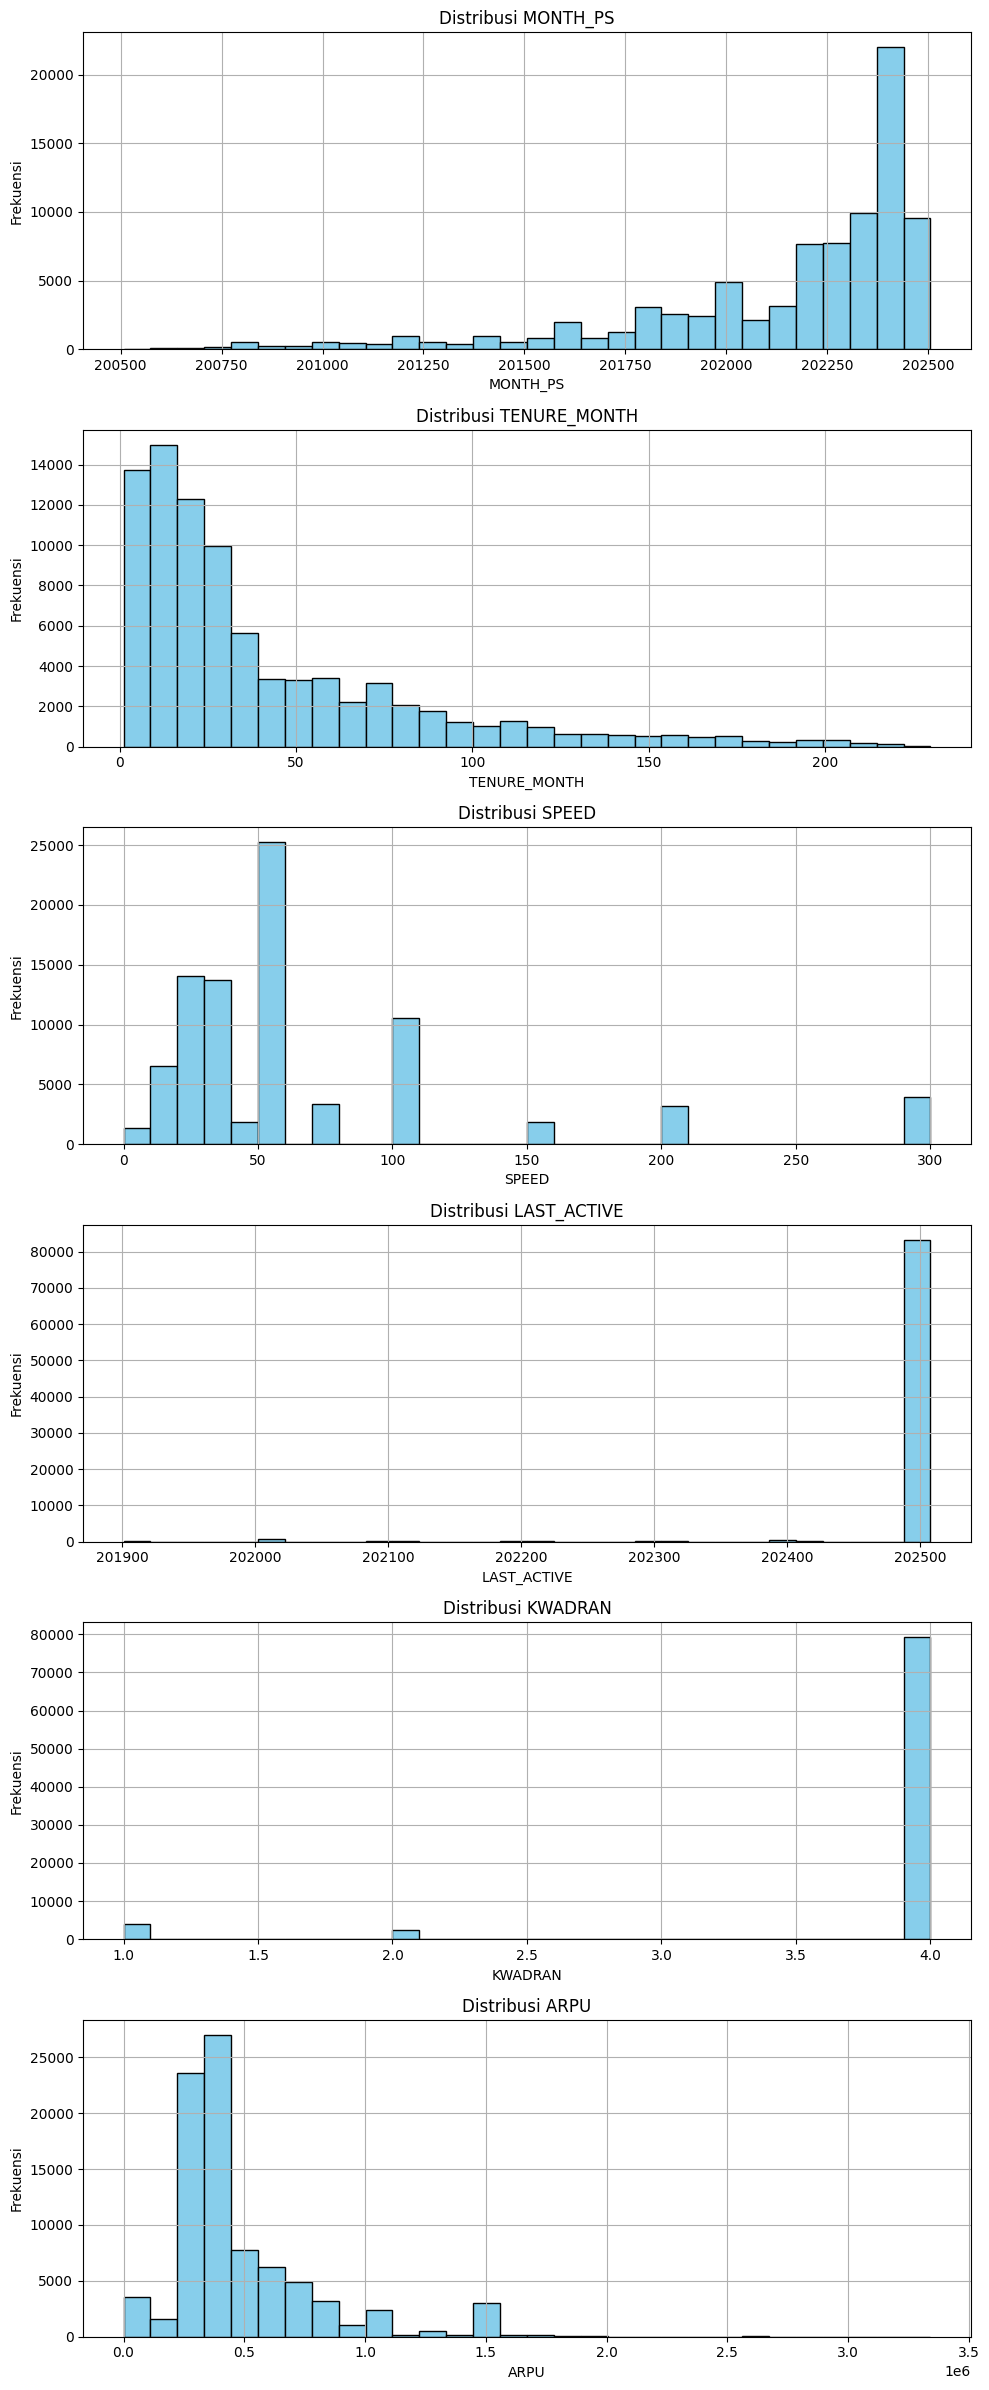

In [36]:
import matplotlib.pyplot as plt

num_cols = test.select_dtypes(include=['number']).columns.tolist()
fig, axes = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(10, 4*len(num_cols)))

for i, col in enumerate(num_cols):
    ax = axes[i] if len(num_cols) > 1 else axes
    test[col].hist(ax=ax, bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribusi {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frekuensi')

plt.tight_layout()
plt.show()